In [50]:
# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
import statsmodels.stats.moment_helpers
from datetime import datetime
import multiprocessing as mp
import csv
import networkx as nx

# functions

def choose_next_input(i,t,input_key):
    index1=input_keys.index(input_key)
    input_key = random.choices(input_keys,weights=grammarmat[input_keys.index(input_key)])[0]
    index2=input_keys.index(input_key)

    tprob=grammarmat[index1,index2]
    
    input = input_dict[input_key]
        
    return input, input_key, tprob


def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets):
    acts = acts*leak + np.dot(input, input_wmat) + np.dot(spikes, wmat)
    
    thresholds = targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    acts[spikes==1]=acts[spikes==1]-thresholds[spikes==1]
    acts[acts<0]=0
       
    errors=acts-targets
    
    return acts, spikes, errors

def learning(learn_on,link_mat,prev_spikes, errors,wmat,targets):
    prev_active= np.argwhere(prev_spikes > 0)[:,0]
    prev_inactive = np.argwhere(prev_spikes<=0)[:,0]
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_inactive,:]=0
    active_neighbors=np.sum(active_neighbors,axis=0)
    
    if learn_on==1:
        d_wmat = np.zeros((nnodes,nnodes))
        d_wmat[:,:]=errors*lrate_wmat
        d_wmat[link_mat==0]=0
        d_wmat[prev_inactive,:]=0
        d_wmat=(d_wmat/active_neighbors)
        d_wmat=np.nan_to_num(d_wmat)
        wmat-=d_wmat
        
        targets=targets+(errors*lrate_targ)
        targets[targets<targ_min]=targ_min
        
    return wmat, targets

# parameter settings
iterations=1000
nnodes=100
p_link=.1 
leak=.75 #works well
lrate_wmat=.1
lrate_targ=.01
targ_min=1
runs=500

# inputs

input_keys=['man_s','dog_s','walks_v','bites_v','dog_o','man_o','_']
input_dict = {
    'man_s':    [1,0,0,0,0],
    'dog_s':    [0,1,0,0,0],
    'walks_v':  [0,0,1,0,0],
    'bites_v':  [0,0,0,1,0],
    'dog_o':    [0,1,0,0,0],
    'man_o':    [1,0,0,0,0],
    '_':        [0,0,0,0,1]
}

grammarmat=np.zeros( (7, 7) )
grammarmat[0,2] = .75; grammarmat[0,3]=.25;
grammarmat[1,2] = .25; grammarmat[1,3]=.75;
grammarmat[2,4] = .75; grammarmat[2,5]=.25;
grammarmat[3,4] = .25; grammarmat[3,5]=.75;
grammarmat[4,6] = 1; 
grammarmat[5,6] = 1; 
grammarmat[6,0] = .5; grammarmat[6,1]=.5;

all_corrs=pd.DataFrame()
all_popcodes=pd.DataFrame()
cross_cor_matrix = np.zeros((7,7))
for run in range(runs):
    print(' ')
    print(run)

    #input mat
    input_wmat=np.zeros((5,nnodes))
    for row in range(input_wmat.shape[0]):
        for col in range(nnodes):
            input_wmat[row,col]=random.choices([0,5], weights=(1-p_link,p_link), k=1)[0]

    #internal weight matrix
    link_mat = np.zeros((nnodes,nnodes))
    for row in range(link_mat.shape[0]):
        for col in range(link_mat.shape[1]):
            if row == col:
                continue
            link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]

    wmat=np.zeros((nnodes,nnodes))
    for row in range(wmat.shape[0]):
        for col in range(wmat.shape[1]):
            if link_mat[row,col] == 1:
                wmat[row,col] = np.random.normal(0,1)

    start_wmat=wmat.copy()

    # run the model
    end_spikes=pd.DataFrame()
    end_acts=pd.DataFrame()
    end_targets=pd.DataFrame()
    end_stream=pd.DataFrame()
    end_errors=pd.DataFrame()
    end_tprobs=pd.DataFrame()

    spikes=np.zeros(nnodes)
    targets=np.repeat(targ_min,nnodes)
    acts=np.zeros(nnodes)

    input_key = '_'

    i=1
    t=0
    learn_on=1
    while i <= iterations:
        t+=1

        input, input_key, tprob = choose_next_input(i,t,input_key)

        prev_spikes = spikes.copy()

        acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

        if ((i % 1000 ==0) | (i == 1)) & (t==1):
            print('   ', i)

        wmat,targets = learning(learn_on,link_mat,prev_spikes, errors, wmat,targets)

        if i > iterations -100:
            end_spikes=end_spikes.append([spikes], ignore_index=True)
            end_acts=end_acts.append([acts], ignore_index=True)
            end_errors=end_errors.append([errors], ignore_index=True)
            end_stream=end_stream.append([input_key], ignore_index=True)
            end_tprobs=end_tprobs.append([tprob], ignore_index=True)
            end_targets=end_targets.append([targets], ignore_index=True)

        if t == 4:
            t=0
            i+=1

    end_wmat=wmat.copy()
    
    #check for pop. codes
    pop_codes=[]
    for word in input_keys:
        arr=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]==word)[:,0],:]
        n=arr.shape[0]
        cor_matrix = np.zeros((n,n))
        for i in range(n):
            spikes1=arr[i,:]
            for j in range(n):
                spikes2=arr[j,:]
                corr = np.around(scipy.stats.pearsonr(spikes1, spikes2)[0],2)
                cor_matrix[i,j]=corr
        pop_codes.append(cor_matrix.mean())
    all_popcodes=all_popcodes.append(pd.DataFrame(np.concatenate(([run],pop_codes))).T)
    
    #cross-corrs
    avg_man_s=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='man_s')[:,0],:].mean(axis=0)
    avg_dog_s=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='dog_s')[:,0],:].mean(axis=0)
    avg_walks_v=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='walks_v')[:,0],:].mean(axis=0)
    avg_bites_v=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='bites_v')[:,0],:].mean(axis=0)
    avg_dog_o=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='dog_o')[:,0],:].mean(axis=0)
    avg_man_o=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='man_o')[:,0],:].mean(axis=0)
    avg_spc=np.array(end_spikes)[np.argwhere(np.array(end_stream)[:,0]=='_')[:,0],:].mean(axis=0)

    avg_array=([avg_man_s,avg_dog_s,avg_walks_v,avg_bites_v,avg_dog_o,avg_man_o,avg_spc])

    for i in range(7):
        arr1=avg_array[i]
        for j in range(i,7):
            arr2=avg_array[j]
            corr = np.around(scipy.stats.pearsonr(arr1, arr2)[0],2)
            cross_cor_matrix[j,i]=cross_cor_matrix[j,i]+corr

    #testing
    learn_on = 1
    for first_input in ['man_s','dog_s']:
        for second_input in ['NA','walks_v','bites_v']:

            spikes=np.array(end_spikes.iloc[end_spikes.shape[0]-1,:])

            acts=np.array(end_acts.iloc[end_acts.shape[0]-1,:])       
            wmat=end_wmat.copy()

            on=True
            while on==True:

                input_key = first_input
                input = input_dict[input_key]

                prev_spikes = spikes.copy()
                acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
                wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)

                if(second_input=='NA'):
                    on=False
                else:
                    input_key = second_input
                    input = input_dict[input_key]

                    prev_spikes = spikes.copy()
                    acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)
                    wmat,targets = learning(learn_on,link_mat,prev_spikes, errors,wmat,targets)
                    on=False

            prev_spikes = spikes.copy()
            input=[0,0,0,0,0]
            acts, spikes, errors = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets)

            results=[]
            for i in range(7):
                word=input_keys[i]
                arr=np.array((end_spikes.iloc[end_stream.index[end_stream[0] == word],:]))
                corrs=[]
                for n in range(arr.shape[0]):
                    x = arr[n,:]
                    corr = np.around(scipy.stats.pearsonr(x, spikes)[0],2)
                    corrs.append(corr)
                res=np.mean(corrs)
                results.append(res)

    #         results=(results - np.min(results)) / (np.max(results) - np.min(results))
    #         results=results/sum(results)
            all_corrs=all_corrs.append(pd.DataFrame(np.concatenate(([run,first_input,second_input],results))).T)

cross_cor_matrix=cross_cor_matrix/runs
cross_cor_matrix=pd.DataFrame(cross_cor_matrix)
cross_cor_matrix.to_csv('cross_corr_matrix_end.csv')
all_popcodes.rename(columns = {0: 'run', 1: input_keys[0], 2:input_keys[1], 3:input_keys[2], 4:input_keys[3], 5:input_keys[4], 6:input_keys[5],7:input_keys[6]}, inplace = True)
all_popcodes.to_csv('all_popcodes_end.csv')
all_corrs.rename(columns = {0: 'run',1:'first_input', 2: 'second_input', 3: input_keys[0],4:input_keys[1],5:input_keys[2],6:input_keys[3],7:input_keys[4],8:input_keys[5],9:input_keys[6]}, inplace = True)
all_corrs.to_csv('all_corrs_end.csv')

 
0
    1


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


    1000
 
1
    1
    1000
 
2
    1
    1000
 
3
    1
    1000
 
4
    1
    1000
 
5
    1
    1000
 
6
    1
    1000
 
7
    1
    1000
 
8
    1
    1000
 
9
    1
    1000
 
10
    1
    1000
 
11
    1
    1000
 
12
    1
    1000
 
13
    1
    1000
 
14
    1
    1000
 
15
    1
    1000
 
16
    1
    1000
 
17
    1
    1000
 
18
    1
    1000
 
19
    1
    1000
 
20
    1
    1000
 
21
    1
    1000
 
22
    1
    1000
 
23
    1
    1000
 
24
    1
    1000
 
25
    1
    1000
 
26
    1
    1000
 
27
    1
    1000
 
28
    1
    1000
 
29
    1
    1000
 
30
    1
    1000
 
31
    1
    1000
 
32
    1
    1000
 
33
    1
    1000
 
34
    1
    1000
 
35
    1
    1000
 
36
    1
    1000
 
37
    1
    1000
 
38
    1
    1000
 
39
    1
    1000
 
40
    1
    1000
 
41
    1
    1000
 
42
    1
    1000
 
43
    1
    1000
 
44
    1
    1000
 
45
    1
    1000
 
46
    1
    1000
 
47
    1
    1000
 
48
    1
    1000
 
49
    1
    1000
 
50
    1
    1000


 
396
    1
    1000
 
397
    1
    1000
 
398
    1
    1000
 
399
    1
    1000
 
400
    1
    1000
 
401
    1
    1000
 
402
    1
    1000
 
403
    1
    1000
 
404
    1
    1000
 
405
    1
    1000
 
406
    1
    1000
 
407
    1
    1000
 
408
    1
    1000
 
409
    1
    1000
 
410
    1
    1000
 
411
    1
    1000
 
412
    1
    1000
 
413
    1
    1000
 
414
    1
    1000
 
415
    1
    1000
 
416
    1
    1000
 
417
    1
    1000
 
418
    1
    1000
 
419
    1
    1000
 
420
    1
    1000
 
421
    1
    1000
 
422
    1
    1000
 
423
    1
    1000
 
424
    1
    1000
 
425
    1
    1000
 
426
    1
    1000
 
427
    1
    1000
 
428
    1
    1000
 
429
    1
    1000
 
430
    1
    1000
 
431
    1
    1000
 
432
    1
    1000
 
433
    1
    1000
 
434
    1
    1000
 
435
    1
    1000
 
436
    1
    1000
 
437
    1
    1000
 
438
    1
    1000
 
439
    1
    1000
 
440
    1
    1000
 
441
    1
    1000
 
442
    1
    1000
 
443
    1
 

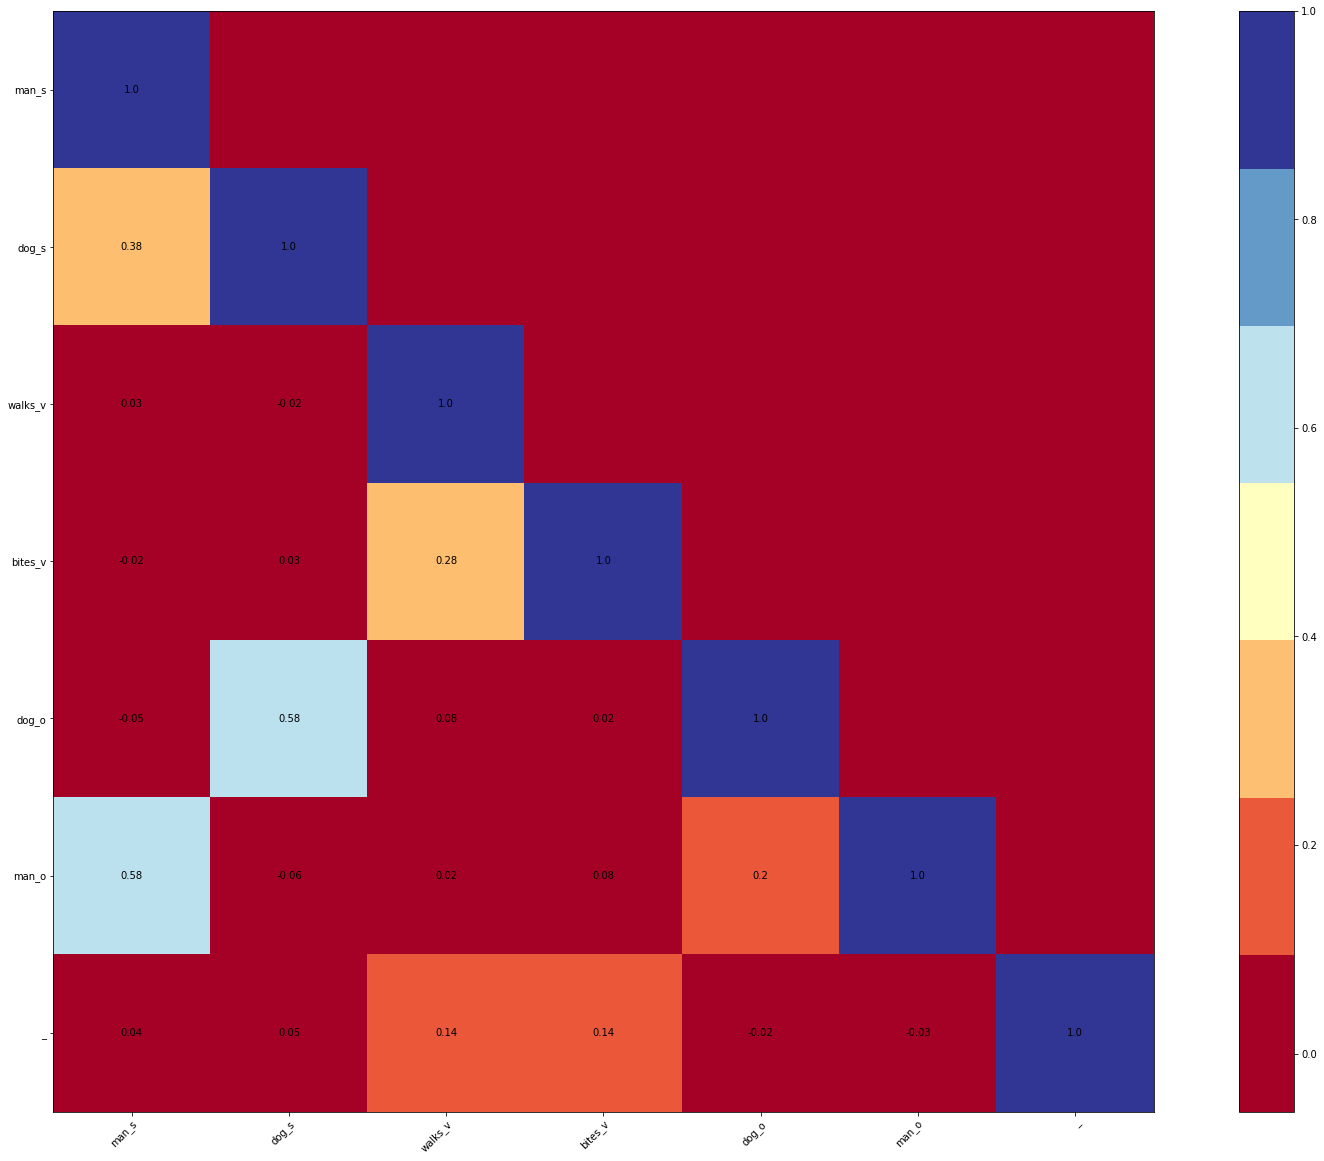

In [51]:
cross_cor_matrix=np.array(cross_cor_matrix)
cmap = cm.get_cmap('RdYlBu', 7)

fig, ax = plt.subplots()
im = ax.imshow(cross_cor_matrix,cmap=cmap)

ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))

ax.set_xticklabels(input_keys)
ax.set_yticklabels(input_keys)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(7):
    for j in range(7):
        if j > i:
            continue
        text = ax.text(j, i, np.around(cross_cor_matrix[i, j],2),
                       ha="center", va="center", color="black")

#name='Fig3.'+ str(input_keys[first_input]) + '.' + str(input_num) +'.png'

plt.colorbar(im, ax=ax)
fig.tight_layout()
fig.set_size_inches(25, 20)
#fig.savefig(name, dpi=100)

plt.show()